# Setup the model

In [1]:
import torch
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

import copy

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


This notebook uses *slowfast* network to extract features of video clips.
documentation about the model can be found at:
https://pytorch.org/hub/facebookresearch_pytorchvideo_slowfast/

This model processes batches of 32 frames each 256x256 pixels, and outputs a vector of 400 probabilities each belonging to one class of kinetics-400 dataset.

The above code follows the model presented in the following paper:
[1] Christoph Feichtenhofer et al, “SlowFast Networks for Video Recognition” https://arxiv.org/pdf/1812.03982.pdf

<img src="files/1.png" width="600">

In [61]:
# Load pretrained model
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in /home/yasamanparhizkar/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [62]:
# Set to GPU or CPU
device = 'cpu'
model = model.eval()
model = model.to(device)

In [63]:
# set model-specific parameters and transforms
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 1
frames_per_second = 60
slowfast_alpha = 4

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

# necessary transform to operate the model
transform = Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    )

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second


# Setup the data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
# load the fish movie
data_path = '../../data/original_files/'

frames = np.loadtxt(data_path + 'frames.csv', delimiter=',')
frames = frames.reshape(frames.shape[0], 120, 200)
print('frames.shape = {}'.format(frames.shape))

frames.shape = (1141, 120, 200)


In [7]:
# define a dataset object for the fish movie
class FishMovieDataset(Dataset):
    """Single frames of the fish movie"""

    def __init__(self, path, transform=None):
        """
        Input: path, nrn_i, transform
        path - path to where 'frames.csv' is stored
        transform - optional preprocessing on frames
        """
        
        frames = np.loadtxt(path + 'frames.csv', delimiter=',')
        frames = frames.reshape(frames.shape[0], 120, 200)
        
        self.frames = frames
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()
            sample = self.frames[idx]
            if self.transform:
                sample = torch.stack([self.transform(Image.fromarray(frm)) for frm in sample])
        
        else:
            sample = self.frames[idx]
            if self.transform:
                sample = self.transform(Image.fromarray(sample))

        return sample
    
    def frame_sz(self):
        return self.frames.shape[1:]
    
    def num_frames(self):
        return self.frames.shape[0]

In [8]:
# Get fish movie dataset with preprocessed frames
fmdata = FishMovieDataset(path=data_path,
                           transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor()
                           ]))

## Create batches of frames withOUT a dataloader

In [9]:
# Helper function to show a batch
def show_frames_batch(sample_batched):
    batch_size = len(sample_batched)
    im_size = sample_batched.size(2)
    grid_border_size = 2

    image_batched = torch.broadcast_to(sample_batched, (batch_size, 3, 256,256))/256
    grid = utils.make_grid(image_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

0 torch.Size([32, 1, 256, 256])


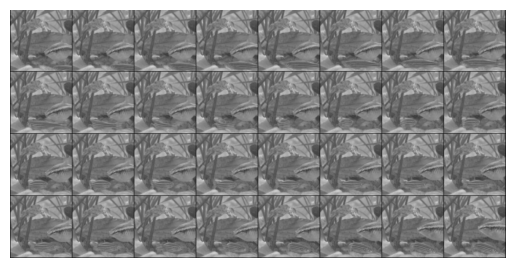

In [10]:
# idx = torch.tensor([1,3,3], dtype=torch.int32)
batch_st = 1000
batch_sz = 32
idx = torch.arange(batch_st, batch_st+batch_sz, dtype=torch.int32)
sample_batched = fmdata[idx]

print('0', sample_batched.size())
plt.figure()
show_frames_batch(sample_batched)
plt.axis('off')
plt.ioff()
plt.show()

# Remove the top layer

In [64]:
# replace last fully connected layer with Identity
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [65]:
# copy the model so the original model doesn't change
model_t = copy.deepcopy(model)

# see layers of the model
# print(model_t)

# delete the top layer - top layer only concatenates the previous layer's output
model_t.blocks[6].dropout = Identity()
model_t.blocks[6].proj = Identity()
model_t.blocks[6].output_pool = Identity()

In [66]:
print(model_t)

Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
      )
      (multipathway_fusion): FuseFastToSlow(
        (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), st

## Evaluate new model (without the top layers)

In [67]:
# create a batch of 32 frames
batch_st = 1000
batch_sz = 32
idx = torch.arange(batch_st, batch_st+batch_sz, dtype=torch.int32)
sample_batched = fmdata[idx]

# perform necessary preprocessing on a batch of 32 frames to be acceptable by the model
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
# 'inputs' is a list of two tensors: slow_pathway and fast_pathway movies. fast_pathway is just a subsample of slow_pathway

# Move the inputs to the desired device
inputs = [i.to(device)[None, ...] for i in inputs]

In [68]:
inputs[1].shape #(N, C, D, H, W)

torch.Size([1, 3, 32, 256, 256])

In [69]:
# Pass the input clip through the model
preds_t = model_t(inputs)
preds_t = preds_t.detach()

In [70]:
print('size of feature vectors: {}'.format(preds_t.size()))
print('norm-2 of this feature vector: {:.4f}'.format(torch.norm(preds_t)))

size of feature vectors: torch.Size([1, 9216])
norm-2 of this feature vector: 29.2810


## Evaluate the model for all batches in the movie
## Alternative title: compute feature vectors

### Save feature vectors

In [50]:
batch_sz = 32
dataset_sz = len(fmdata) - batch_sz + 1
# dataset_sz = 5
f_sz = 9216

def slowfast_ft(batch_sz, dataset_sz, model=model_t, fmdata=fmdata, transform=transform, path='../../data/slowfast_9216/'):
    for batch_st in range(dataset_sz):
        idx = torch.arange(batch_st, batch_st+batch_sz, dtype=torch.int32)
        sample_batched = fmdata[idx]

        sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
        sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
        inputs = transform(sample_batched)
        inputs = [i.to(device)[None, ...] for i in inputs]

        preds = model(inputs)
        preds = preds.detach()
        torch.save(preds, path+'fv_'+str(batch_st)+'.pt')
        # print(batch_st, preds.size())
        
    return len(preds)

In [51]:
# slowfast_ft(batch_sz, dataset_sz, model_t, fmdata, transform, path='../../data/slowfast_9216/')

### Load feature vectors

In [52]:
# # load feature vectors - method 1
# fvs = []
# for vect_i in range(dataset_sz):
#     fvs.append(torch.load('../../data/slowfast_9216/fv_'+str(vect_i)+'.pt'))

# fvs = torch.cat(fvs)

In [53]:
# load feature vectors - method 2
fvs = torch.cat([torch.load('../../data/slowfast_9216/fv_'+str(vect_i)+'.pt') for vect_i in range(dataset_sz)])

# Sanity checks

## 1. Neighbouring node
Neighbouring nodes (with 31 overlapping frames out of 32 frames) should have closer features than farther nodes.

Measuring closeness with norm-2 of difference in this section.

In [142]:
base_i = 528
base_v = fvs[base_i]
print('Norm of difference with vector #{}'.format(base_i))
for vect_i in range(dataset_sz):
    if vect_i == base_i:
        print('vvv Base Vector:')
    print('{}:\t{:.6f}'.format(vect_i, torch.norm(fvs[vect_i]-base_v)))

Norm of difference with vector #528
0:	25.293888
1:	25.363010
2:	25.243332
3:	25.356405
4:	25.178326
5:	25.464672
6:	25.312084
7:	25.499851
8:	25.347601
9:	25.750334
10:	25.517368
11:	25.506132
12:	25.500584
13:	25.430122
14:	25.239126
15:	25.332359
16:	25.457104
17:	25.365734
18:	25.407238
19:	25.575085
20:	25.780903
21:	25.636488
22:	25.577019
23:	25.471071
24:	25.434540
25:	25.424974
26:	25.435715
27:	25.457418
28:	25.536793
29:	25.387363
30:	25.567867
31:	25.568151
32:	25.495399
33:	25.519022
34:	25.469995
35:	25.349182
36:	25.517817
37:	25.520231
38:	25.487104
39:	25.394423
40:	25.633137
41:	25.416683
42:	25.255804
43:	25.244989
44:	25.357145
45:	25.442162
46:	25.345743
47:	25.494450
48:	25.447987
49:	25.611561
50:	25.447025
51:	25.676996
52:	25.706360
53:	25.439688
54:	25.389793
55:	25.610964
56:	25.252747
57:	25.350451
58:	25.339636
59:	25.316216
60:	25.348261
61:	25.297779
62:	25.207150
63:	25.382408
64:	25.362061
65:	25.210363
66:	25.206224
67:	25.073322
68:	25.056587
69:	24.7

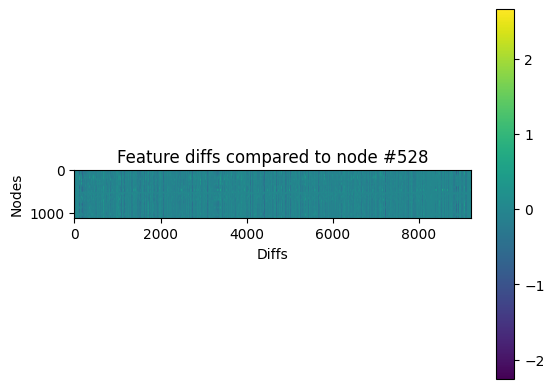

In [143]:
# plot differences
bases = torch.broadcast_to(fvs[base_i][None, :], (dataset_sz, f_sz))

plt.figure()
plt.imshow(fvs - bases)
plt.colorbar()
plt.ylabel('Nodes')
plt.xlabel('Diffs')
plt.title('Feature diffs compared to node #{}'.format(base_i))
plt.show()

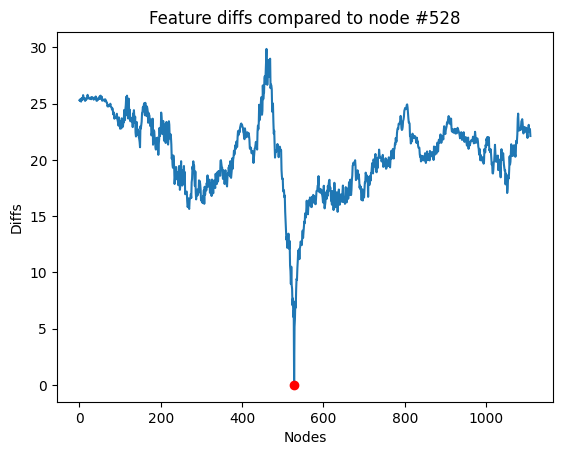

In [144]:
# plot differences
plt.figure()
plt.plot(torch.norm(fvs - bases, dim=1))
plt.plot(base_i, 0, marker='o', color='r', linestyle='')
plt.ylabel('Diffs')
plt.xlabel('Nodes')
plt.title('Feature diffs compared to node #{}'.format(base_i))
plt.show()

## Gaussian Noise / DC value

Add Gaussian noise to frames and extract features. 
Should witness Gaussina noise in features as well. 
Try various means and std's.

Guassian noise with std=0 and mean=DC, is just adding DC to all pixels.
Features logically should not change by a DC term, since it does not represent motion or contrast or any significan feature.
However, a bit of change in constrast happens, since all values higher than 255 get clipped.

In [225]:
# create noise
gn_mean = 0
gn_std = 50
gn = torch.normal(mean=gn_mean, std=gn_std, size=(32, 1, 256, 256))
gn

tensor([[[[  -4.7901,   20.8881,   21.4770,  ...,   51.2582,   39.5806,
             45.5740],
          [  26.2092,   91.8906,   44.3794,  ...,   13.3965,  -27.3363,
            -37.1099],
          [  11.9567,   -8.4341,   41.3144,  ...,   87.9538,   84.8643,
             -1.1839],
          ...,
          [  49.1166, -100.4258,  -50.8775,  ..., -111.4420,  -89.5964,
             24.3128],
          [ -56.0471,   62.9272,  -30.0633,  ...,  -82.5696,  -37.5776,
             38.5984],
          [  46.8234,  -25.5255,   25.8976,  ...,   15.4831,    3.5150,
            -93.7297]]],


        [[[ -18.5613,   49.7179,   53.4724,  ...,  -54.5939,  -17.2277,
             74.5239],
          [ -32.1612,   22.5378,  -68.2146,  ...,   15.4124,  -36.3185,
              0.9717],
          [   4.0747,   64.3634,  -76.2673,  ...,  -20.6106,  -33.3689,
              2.1248],
          ...,
          [ -48.0005,  -40.8610,   16.8471,  ...,  -66.8740,   69.1611,
            -28.9693],
          [  26.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([32, 1, 256, 256])


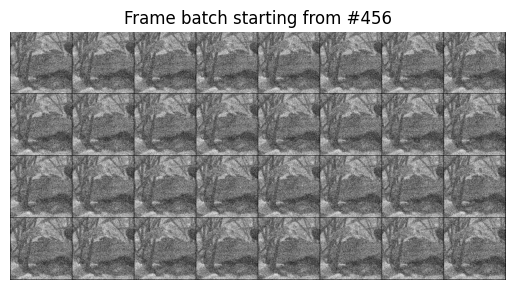

In [226]:
# add noise to frame batch
batch_st = 456
idx = torch.arange(batch_st, batch_st+batch_sz, dtype=torch.int32)
sample_batched = fmdata[idx]
# sample_batched = torch.clamp(sample_batched + gn, min=0, max=255)
sample_batched = sample_batched + gn

print('0', sample_batched.size())
plt.figure()
show_frames_batch(sample_batched)
plt.title('Frame batch starting from #{}'.format(batch_st))
plt.axis('off')
plt.ioff()
plt.show()

In [227]:
# extract features of noisy frame batch
sample_batched = torch.broadcast_to(sample_batched, (32, 3, 256,256))
sample_batched = sample_batched.transpose(0,1) # because a pytorch movie clip is describes as a tensor of shape (C, T, H, W)
inputs = transform(sample_batched)
inputs = [i.to(device)[None, ...] for i in inputs]

preds = model_t(inputs)
preds = preds.detach()

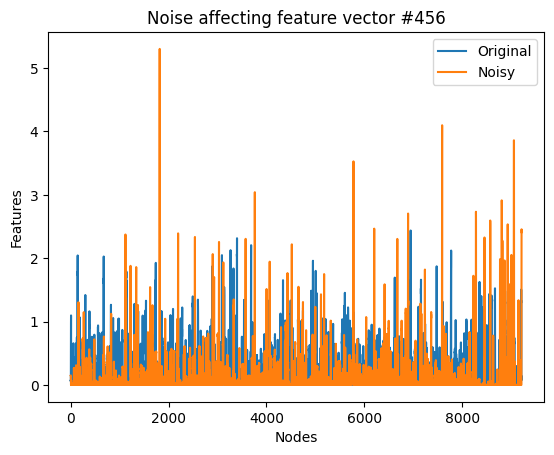

In [228]:
# plot original and noisy vectors
plt.figure()
plt.plot(fvs[batch_st])
plt.plot(preds[0])
plt.xlabel('Nodes')
plt.ylabel('Features')
plt.legend(['Original', 'Noisy'])
plt.title('Noise affecting feature vector #{}'.format(batch_st))
# plt.ylim([-0.1, 3])
plt.show()